In [1]:
# 📦 Imports
import os
import ast
import json
import math
import yaml
import logging
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import seaborn as sns

from shapely.geometry import box, Point
from pyproj import Transformer
from dotenv import load_dotenv
from pathlib import Path
from dotenv import load_dotenv
import rasterio
from joblib import Parallel, delayed
from tqdm import tqdm
import pickle
import requests
from rasterio.mask import mask as rio_mask
from shapely.geometry import mapping
load_dotenv()

pd.set_option("display.max_columns", 250)
pd.set_option("display.max_rows", 250)

logging.basicConfig(
    format="%(asctime)s [%(levelname)s] %(message)s",
    level=logging.INFO
)
log = logging.getLogger(__name__)


In [66]:
def load_dem_data(dem_type, aoi, out_file, interim_dir="."):
    """
    Downloads DEM from OpenTopography API and saves as GeoTIFF.

    Parameters:
        dem_type    : str   - DEM product name, e.g. "SRTMGL3"
        aoi         : list  - bounding box [min_lon, min_lat, max_lon, max_lat]
        out_file    : str   - output filename (e.g. "region_1_srtmgl3_90m.tif")
        interim_dir : str   - directory to save the file

    Returns:
        str - Full path to the saved DEM file
    """
    url = "https://portal.opentopography.org/API/globaldem"
    params = {
        "demtype":      dem_type,
        "west":         aoi[0],
        "south":        aoi[1],
        "east":         aoi[2],
        "north":        aoi[3],
        "outputFormat": "GTiff",
        "API_Key":      OPENTOPO_KEY,
    }

    os.makedirs(interim_dir, exist_ok=True)
    out_path = os.path.join(interim_dir, out_file)

    print(f"→ Requesting DEM from OpenTopography for: {aoi}")
    response = requests.get(url, params=params, timeout=180)
    response.raise_for_status()

    with open(out_path, "wb") as f:
        f.write(response.content)
    print("✔ DEM saved to:", out_path)

    # Quick check
    try:
        with rasterio.open(out_path) as src:
            arr = src.read(1)
            print("DEM shape:", arr.shape)
            print("DEM min/max:", np.nanmin(arr), "/", np.nanmax(arr))
    except Exception as e:
        print("⚠ Error reading DEM:", e)

    return out_path


def add_relief_features(gdf: gpd.GeoDataFrame, dem_path: str) -> gpd.GeoDataFrame:
    """
    Adds `mean_elev_m` and `mean_slope_deg` to GeoDataFrame using a DEM raster.

    Parameters:
        gdf       : GeoDataFrame - input with polygon geometries
        dem_path  : str          - path to DEM GeoTIFF

    Returns:
        GeoDataFrame - with added columns
    """
    means, slopes = [], []
    with rasterio.open(dem_path) as src:
        crs_dem = src.crs
        transform = src.transform
        arr = src.read(1).astype(np.float32)
        nodata = src.nodata
        if nodata is not None and nodata != 0:
            arr[arr == nodata] = np.nan
        dx, dy = abs(transform.a), abs(transform.e)

        # Compute slope
        dzdx = np.gradient(arr, dx, axis=1)
        dzdy = np.gradient(arr, dy, axis=0)
        slope_arr = np.degrees(np.arctan(np.hypot(dzdx, dzdy)))

        for poly in tqdm(gdf.to_crs(crs_dem).geometry, desc="relief"):
            try:
                window, _ = rio_mask(src, [mapping(poly)], crop=True, filled=False)
                band = window[0]
                means.append(float(np.nanmean(band)))
                cen = poly.centroid
                row, col = src.index(cen.x, cen.y)
                slopes.append(float(slope_arr[row, col]))
            except Exception:
                means.append(np.nan)
                slopes.append(np.nan)

    out = gdf.copy()
    out["mean_elev_m"]    = means
    out["mean_slope_deg"] = slopes
    return out


def add_geometry_point(gdf: gpd.GeoDataFrame,
                       method: str = "centroid") -> gpd.GeoDataFrame:
    """
    Adds a `geometry_point` column to the GeoDataFrame:
    • "centroid" — center of polygon,
    • "first_vert" — first vertex of outer ring,
    • "bounds" — lower-left corner of bounding box.
    """
    if "geometry" not in gdf.columns:
        raise ValueError("gdf must have a 'geometry' column.")

    def _make_point(poly):
        if poly is None or poly.is_empty:
            return None
        if method == "centroid":
            return poly.centroid
        elif method == "first_vert":
            x, y = poly.exterior.coords[0]
            return Point(x, y)
        elif method == "bounds":
            minx, miny, *_ = poly.bounds
            return Point(minx, miny)
        else:
            raise ValueError("Method must be 'centroid', 'first_vert', or 'bounds'.")

    out = gdf.copy()
    out["geometry_point"] = out.geometry.apply(_make_point)
    return out

def flag_mountains(gdf: gpd.GeoDataFrame,
                   slope_field: str = "mean_slope_deg",
                   slope_thr: float = 20,
                   elev_thr: float = 300,
                   out_col: str = "is_mountain") -> gpd.GeoDataFrame:
    """
    Flags tiles as mountainous where slope > slope_thr and elevation > elev_thr.
    """
    condition = (gdf[slope_field] > slope_thr) & (gdf["mean_elev_m"] > elev_thr)
    out = gdf.copy()
    out[out_col] = condition
    return out

def add_distance_to_mountains(gdf: gpd.GeoDataFrame,
                              mountain_col: str = "is_mountain",
                              point_col: str = "geometry_point",
                              out_col: str = "dist_to_mountain_m") -> gpd.GeoDataFrame:
    """
    Computes distance from each tile to the nearest mountainous tile (in meters).
    """
    pts = np.array([[p.x, p.y] for p in gdf.loc[gdf[mountain_col], point_col]])
    dists = []
    for _, row in tqdm(gdf.iterrows(), total=len(gdf), desc="dist2mountain"):
        pt = row[point_col]
        if row[mountain_col]:
            dists.append(0.0)
        elif pts.size:
            dists.append(float(np.hypot(pts[:,0]-pt.x, pts[:,1]-pt.y).min()))
        else:
            dists.append(np.nan)
    out = gdf.copy()
    out[out_col] = dists
    return out   


def get_distance_to_rivers_parallel(
    geo_gdf: gpd.GeoDataFrame,
    riv_gdf: gpd.GeoDataFrame,
    geometry_col: str = "geometry",
    n_jobs: int = -1
) -> gpd.GeoDataFrame:
    """
    То же самое, но с параллелизацией (Joblib + threads).
    """
    if geometry_col not in geo_gdf.columns:
        raise ValueError(f"Колонка '{geometry_col}' не найдена в geo_gdf.")

    river_union = riv_gdf.geometry.unary_union

    def _dist(pt):
        return pt.distance(river_union) if pt else None

    distances = Parallel(n_jobs=n_jobs, prefer="threads")(
        delayed(_dist)(pt)
        for pt in tqdm(geo_gdf[geometry_col], desc=f"dist-to-river ({geometry_col})")
    )

    out = geo_gdf.copy()
    out["dist_to_river_m"] = distances
    return out

# def get_distance_to_rivers_parallel(geo_gdf, riv_gdf, geometry_col="geometry", n_jobs=-1):
#     river_union = riv_gdf.geometry.unary_union
#     def _dist(pt): return pt.distance(river_union) if pt else None
#     distances = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(_dist)(pt) for pt in tqdm(geo_gdf[geometry_col], desc="dist-to-river"))
#     out = geo_gdf.copy()
#     out["dist_to_river_m"] = distances
#     return out


def compute_drainage_density(
    tiles_gdf,
    rivers_gdf,
    tile_geom_col: str = "geometry",
    river_geom_col: str = "geometry",
    metric_crs: str = "EPSG:3857",
    source_crs: str = "EPSG:4326"):

    # Ensure input is GeoDataFrame
    tiles = tiles_gdf.copy().set_geometry(tile_geom_col)
    rivers = rivers_gdf.copy().set_geometry(river_geom_col)

    # Detect and set CRS if missing
    if tiles.crs is None:
        bounds = tiles.total_bounds
        tiles.set_crs(metric_crs if abs(bounds[2]) > 180 else source_crs, inplace=True)
    if rivers.crs is None:
        bounds = rivers.total_bounds
        rivers.set_crs(metric_crs if abs(bounds[2]) > 180 else source_crs, inplace=True)

    # Reproject to metric CRS
    tiles = tiles.to_crs(metric_crs)
    rivers = rivers.to_crs(metric_crs)

    # Build spatial index
    sindex = rivers.sindex

    lengths = []
    areas = []
    densities = []

    for poly in tqdm(tiles.geometry, desc="drainage_density", unit="tile"):
        area_km2 = poly.area / 1e6
        idxs = list(sindex.intersection(poly.bounds))

        if not idxs:
            length_m = 0.0
        else:
            candidates = rivers.iloc[idxs]
            inter = candidates[candidates.geometry.intersects(poly)]
            if inter.empty:
                length_m = 0.0
            else:
                clipped = inter.geometry.intersection(poly)
                length_m = clipped.length.sum()

        lengths.append(length_m)
        areas.append(area_km2)
        densities.append((length_m / 1000) / area_km2 if area_km2 > 0 else np.nan)

    out = tiles_gdf.copy()
    out["drainage_density_m"] = lengths
    out["tile_area_km2"] = areas
    out["drainage_density"] = densities
    return out


def flatten_tile_hits_with_negatives(tiles_tagged: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    Для каждого тайла:
     – если есть ≥1 геоглифа: по одному ряду на каждый геоглиф;
     – иначе: один ряд с None.
    Сохраняет остальные признаки и geometry.
    """
    list_cols = [c for c in tiles_tagged.columns if c.endswith("_list")]
    static_cols = [c for c in tiles_tagged.columns if c not in list_cols + ["geometry"]]
    records = []
    for _, row in tiles_tagged.iterrows():
        n = int(row.get("n_geoglyphs", 0))
        if n > 0:
            for i in range(n):
                rec = {c: row[c] for c in static_cols}
                rec["geometry"] = row.geometry
                for lc in list_cols:
                    fld = lc[:-5]
                    lst = row[lc] or []
                    rec[fld] = lst[i] if i < len(lst) else None
                records.append(rec)
        else:
            rec = {c: row[c] for c in static_cols}
            rec["geometry"] = row.geometry
            for lc in list_cols:
                rec[lc[:-5]] = None
            records.append(rec)
    df = pd.DataFrame.from_records(records)
    return gpd.GeoDataFrame(df, geometry="geometry", crs=tiles_tagged.crs)


def add_geometry_point(gdf: gpd.GeoDataFrame,
                       method: str = "centroid") -> gpd.GeoDataFrame:
    """
    Adds a `geometry_point` column to the GeoDataFrame using one of the methods:
    - "centroid": polygon centroid
    - "first_vert": first vertex of the outer ring
    - "bounds": lower-left corner of bounding box

    Ensures CRS is preserved.
    """
    if "geometry" not in gdf.columns:
        raise ValueError("GeoDataFrame must contain a 'geometry' column.")

    def _make_point(poly):
        if poly is None or poly.is_empty:
            return None
        if method == "centroid":
            return poly.centroid
        elif method == "first_vert":
            x, y = poly.exterior.coords[0]
            return Point(x, y)
        elif method == "bounds":
            minx, miny, *_ = poly.bounds
            return Point(minx, miny)
        else:
            raise ValueError("Invalid method: must be 'centroid', 'first_vert' or 'bounds'.")

    out = gdf.copy()
    out["geometry_point"] = gpd.GeoSeries(out.geometry.apply(_make_point), crs=gdf.crs)
    return out


def add_country_field(tiles: gpd.GeoDataFrame,
                      countries_gdf: gpd.GeoDataFrame,
                      point_col: str = "geometry_point",
                      new_col: str = "country") -> gpd.GeoDataFrame:
    """
    Adds a country name column to tiles GeoDataFrame based on point-in-polygon join.

    Parameters:
    - tiles: GeoDataFrame with tile polygons and geometry points
    - countries_gdf: GeoDataFrame with country polygons
    - point_col: name of point column (used as join geometry)
    - new_col: name of the output country column
    """
    pts = tiles.copy()
    if not all(pts.geometry.geom_type == "Point"):
        pts = pts.set_geometry(point_col)

    if pts.crs is None:
        pts = pts.set_crs(countries_gdf.crs, allow_override=True)
    elif pts.crs != countries_gdf.crs:
        pts = pts.to_crs(countries_gdf.crs)

    joined = gpd.sjoin(pts, countries_gdf, how="left", predicate="within")
    out = tiles.copy()
    out[new_col] = joined["name"]
    return out


def flatten_tile_hits_with_negatives(tiles_tagged: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    For each tile:
    - If n_geoglyphs > 0: expands into one row per geoglyph (using *_list fields)
    - If n_geoglyphs == 0: retains one row with None values

    Keeps static features and geometry unchanged.
    """
    list_cols = [c for c in tiles_tagged.columns if c.endswith("_list")]
    static_cols = [c for c in tiles_tagged.columns if c not in list_cols + ["geometry"]]
    records = []

    for _, row in tiles_tagged.iterrows():
        n = int(row.get("n_geoglyphs", 0))
        if n > 0:
            for i in range(n):
                rec = {c: row[c] for c in static_cols}
                rec["geometry"] = row.geometry
                for lc in list_cols:
                    base = lc[:-5]
                    lst = row[lc] or []
                    rec[base] = lst[i] if i < len(lst) else None
                records.append(rec)
        else:
            rec = {c: row[c] for c in static_cols}
            rec["geometry"] = row.geometry
            for lc in list_cols:
                rec[lc[:-5]] = None
            records.append(rec)

    df = pd.DataFrame.from_records(records)
    return gpd.GeoDataFrame(df, geometry="geometry", crs=tiles_tagged.crs)


def load_country_shapes(crs: str = "EPSG:3857",
                        use_bbox: bool = False,
                        countries: list = None) -> gpd.GeoDataFrame:
    """
    Loads country polygons from Natural Earth and filters by country names.
    Reprojects to the given CRS.

    Parameters:
    - crs: target CRS (default: metric)
    - use_bbox: whether to convert geometries to bounding boxes
    - countries: list of country names to include

    Returns:
    - GeoDataFrame with ['name', 'geometry']
    """
    if countries is None:
        countries = [
            "Brazil", "Bolivia", "Colombia", "Ecuador", "Guyana",
            "Peru", "Suriname", "Venezuela", "French Guiana"
        ]

    try:
        from geodatasets import get_path
        world = gpd.read_file(get_path("naturalearth_lowres"))
    except:
        url = ("https://naciscdn.org/naturalearth/110m/cultural/"
               "ne_110m_admin_0_countries.zip")
        world = gpd.read_file(url)

    name_col = next(c for c in ("NAME", "ADMIN", "NAME_EN") if c in world.columns)
    world = world.rename(columns={name_col: "name"})

    mask = world["name"].str.lower().isin([c.lower() for c in countries])
    world = world[mask].to_crs(crs)

    if use_bbox:
        world["geometry"] = world.geometry.bounds.apply(lambda r: box(*r), axis=1)

    return world[["name", "geometry"]]

In [3]:
# 📁 Load paths from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

RAW_DIR = Path(config["raw_data_dir"])
PROCESSED_DIR = Path(config["processed_data_dir"])
RESULTS_DIR = Path(config["results_dir"])
AOI_CRS = config["aoi_crs"]
METRIC_CRS = config["metric_crs"]
AOI_BOX = tuple(config["aoi_box"])
DEM_TYPE = "SRTMGL3"

OPENTOPO_KEY = os.getenv("OPENTOPO_KEY")
if OPENTOPO_KEY is None:
    raise EnvironmentError("❌ Missing OPENTOPO_KEY in your .env file")

In [4]:
# 📥 Load all tagged tile files
regions_gdf = {}
for i in range(1, 7):
    fp = PROCESSED_DIR / f"region_{i}_tagged_with_site.gpkg"
    if not fp.exists():
        raise FileNotFoundError(f"Missing: {fp}")
    gdf = gpd.read_file(fp).to_crs(AOI_CRS)
    regions_gdf[f"region_{i}"] = gdf
    print(f"✔ Loaded region_{i}: {len(gdf)} records")


✔ Loaded region_1: 29701 records
✔ Loaded region_2: 39343 records
✔ Loaded region_3: 31564 records
✔ Loaded region_4: 32909 records
✔ Loaded region_5: 29853 records
✔ Loaded region_6: 4381 records


In [5]:
def load_main_rivers():
    """Load HydroRIVERS and filter major rivers."""
    rivers_path = RAW_DIR / "datasets/hydrorivers-dataset/HydroRIVERS.gdb"
    rivers = gpd.read_file(rivers_path, bbox=AOI_BOX)
    rivers = rivers[rivers["ORD_FLOW"].astype(float) <= 6]
    return rivers.to_crs(METRIC_CRS)

main_rivers_web = load_main_rivers()

In [6]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

dem_path = "data/raw/region_1_srtmgl3_90m.tif"

with rasterio.open(dem_path) as src:
    print("DEM CRS:", src.crs)
    print("DEM bounds:", src.bounds)

# Проверим CRS и bounds тайлов
test = regions_gdf["region_1"]
print("TILE CRS:", test.crs)
print("TILE bounds:", test.total_bounds)

DEM CRS: EPSG:4326
DEM bounds: BoundingBox(left=-80.85875000002252, bottom=-18.197916666648897, right=-65.7095833333593, top=-3.4237499999855885)
TILE CRS: EPSG:4326
TILE bounds: [-80.85833  -18.1988   -65.708936  -3.424391]


In [7]:
regions_gdf['region_1']

,tile_id,n_geoglyphs,has_geoglyph,name_list,coordinates_list,source_list,bbox_list,longitude_list,latitude_list,geometry
0,122412,0,False,[],[],[],[],[],[],"POLYGON ((-80.55834 -3.49939, -80.55834 -3.424..."
1,122413,0,False,[],[],[],[],[],[],"POLYGON ((-80.48334 -3.49939, -80.48334 -3.424..."
2,122414,0,False,[],[],[],[],[],[],"POLYGON ((-80.40835 -3.49939, -80.40835 -3.424..."
3,122415,0,False,[],[],[],[],[],[],"POLYGON ((-80.33335 -3.49939, -80.33335 -3.424..."
4,122416,0,False,[],[],[],[],[],[],"POLYGON ((-80.25835 -3.49939, -80.25835 -3.424..."
...,...,...,...,...,...,...,...,...,...,...
29696,240787,0,False,[],[],[],[],[],[],"POLYGON ((-66.5339 -18.1988, -66.5339 -18.1238..."
29697,240788,0,False,[],[],[],[],[],[],"POLYGON ((-66.45891 -18.1988, -66.45891 -18.12..."
29698,240789,0,False,[],[],[],[],[],[],"POLYGON ((-66.38391 -18.1988, -66.38391 -18.12..."
29699,240790,0,False,[],[],[],[],[],[],"POLYGON ((-66.30891 -18.1988, -66.30891 -18.12..."


In [8]:

relief_regions = {}

for region_name, gdf in regions_gdf.items():
    print(f"\n🌍 Processing {region_name}")

    gdf_geo = gdf.to_crs(AOI_CRS)
    minx, miny, maxx, maxy = gdf_geo.total_bounds
    aoi_bbox = [minx, miny, maxx, maxy]
    print(f"• BBOX: {aoi_bbox}")

    dem_file = f"{region_name.lower()}_{DEM_TYPE.lower()}_90m.tif"
    dem_path = load_dem_data(
        dem_type   = DEM_TYPE,
        aoi        = aoi_bbox,
        out_file   = dem_file,
        interim_dir = "data/raw"
    )

    gdf_relief = add_relief_features(gdf, dem_path)

    relief_regions[region_name] = gdf_relief
    print(f"✔ Relief features computed: {len(gdf_relief)} rows")



🌍 Processing region_1
• BBOX: [-80.85832999999998, -18.198800000000006, -65.70893599999998, -3.4243910000000035]
→ Requesting DEM from OpenTopography for: [-80.85832999999998, -18.198800000000006, -65.70893599999998, -3.4243910000000035]
✔ DEM saved to: data/raw/region_1_srtmgl3_90m.tif
DEM shape: (17729, 18179)
DEM min/max: -660 / 6738


relief:   0%|          | 0/29701 [00:00<?, ?it/s]/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
relief:   0%|          | 137/29701 [00:00<00:43, 680.02it/s]/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
relief:   1%|          | 346/29701 [00:00<00:42, 692.97it/s]/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
relief:   2%|▏         | 556/29701 [00:00<00:42, 691.42it/s]/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
relief:  26%|██▌       | 7791/29701 [00:11<00:30, 711.38it/s]/tmp/ipykernel_181/338345053.py:78: User

✔ Relief features computed: 29701 rows

🌍 Processing region_2
• BBOX: [-65.78393299999998, -18.198800000000006, -50.63453899999997, -3.4243910000000035]
→ Requesting DEM from OpenTopography for: [-65.78393299999998, -18.198800000000006, -50.63453899999997, -3.4243910000000035]
✔ DEM saved to: data/raw/region_2_srtmgl3_90m.tif
DEM shape: (17729, 18179)
DEM min/max: -116 / 4662


relief: 100%|██████████| 39343/39343 [00:57<00:00, 688.58it/s]


✔ Relief features computed: 39343 rows

🌍 Processing region_3
• BBOX: [-50.70953599999997, -18.198800000000006, -35.63513899999997, -3.4243910000000035]
→ Requesting DEM from OpenTopography for: [-50.70953599999997, -18.198800000000006, -35.63513899999997, -3.4243910000000035]
✔ DEM saved to: data/raw/region_3_srtmgl3_90m.tif
DEM shape: (17729, 18089)
DEM min/max: -50 / 2021


relief:   0%|          | 137/31564 [00:00<00:45, 684.00it/s]/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
relief:   1%|          | 275/31564 [00:00<00:45, 682.80it/s]/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
relief:   1%|▏         | 413/31564 [00:00<00:45, 677.21it/s]/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
relief:   2%|▏         | 617/31564 [00:00<00:45, 676.00it/s]/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to n

✔ Relief features computed: 31564 rows

🌍 Processing region_4
• BBOX: [-80.85832999999998, -3.4993880000000037, -65.70893599999998, 11.500011999999998]
→ Requesting DEM from OpenTopography for: [-80.85832999999998, -3.4993880000000037, -65.70893599999998, 11.500011999999998]
✔ DEM saved to: data/raw/region_4_srtmgl3_90m.tif
DEM shape: (17999, 18179)
DEM min/max: -189 / 6259


relief:   0%|          | 0/32909 [00:00<?, ?it/s]/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykerne

✔ Relief features computed: 32909 rows

🌍 Processing region_5
• BBOX: [-65.78393299999998, -3.4993880000000037, -50.63453899999997, 10.900035999999997]
→ Requesting DEM from OpenTopography for: [-65.78393299999998, -3.4993880000000037, -50.63453899999997, 10.900035999999997]
✔ DEM saved to: data/raw/region_5_srtmgl3_90m.tif
DEM shape: (17279, 18179)
DEM min/max: -119 / 6138


relief:   0%|          | 0/29853 [00:00<?, ?it/s]/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
relief:   0%|          | 68/29853 [00:00<00:44, 675.05it/s]/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to

✔ Relief features computed: 29853 rows

🌍 Processing region_6
• BBOX: [-50.70953599999997, -3.4993880000000037, -38.78501299999997, 2.5003719999999987]
→ Requesting DEM from OpenTopography for: [-50.70953599999997, -3.4993880000000037, -38.78501299999997, 2.5003719999999987]
✔ DEM saved to: data/raw/region_6_srtmgl3_90m.tif
DEM shape: (7200, 14309)
DEM min/max: -69 / 1586


relief:   0%|          | 0/4381 [00:00<?, ?it/s]/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel_181/338345053.py:78: UserWarning: Warning: converting a masked element to nan.
  means.append(float(np.nanmean(band)))
/tmp/ipykernel

✔ Relief features computed: 4381 rows


In [9]:
test = relief_regions['region_1']
test['mean_elev_m'].unique()

array([           nan, 3.10000000e+00, 4.66666667e+00, ...,
       3.67412759e+03, 3.88175006e+03, 2.96330261e+03])

In [10]:
regions_final = {}

for name, gdf in relief_regions.items():
    print(f"🏔 Processing {name}")
    
    # 1. Ensure geometry_point exists
    if "geometry_point" not in gdf.columns:
        gdf = add_geometry_point(gdf, method="centroid")
    
    # 2. Flag mountainous tiles
    gdf = flag_mountains(
        gdf,
        slope_field="mean_slope_deg",
        slope_thr=20,
        elev_thr=300,
        out_col="is_mountain"
    )
    
    # 3. Compute distance to nearest mountainous tile
    gdf = add_distance_to_mountains(
        gdf,
        mountain_col="is_mountain",
        point_col="geometry_point",
        out_col="dist_to_mountain_m"
    )
    
    # 4. Store updated region
    regions_final[name] = gdf


🏔 Processing region_1


dist2mountain: 100%|██████████| 29701/29701 [00:06<00:00, 4730.00it/s] 


🏔 Processing region_2


dist2mountain: 100%|██████████| 39343/39343 [00:09<00:00, 4167.35it/s]


🏔 Processing region_3


dist2mountain: 100%|██████████| 31564/31564 [00:06<00:00, 4852.97it/s] 


🏔 Processing region_4


dist2mountain: 100%|██████████| 32909/32909 [00:06<00:00, 5198.63it/s]


🏔 Processing region_5


dist2mountain: 100%|██████████| 29853/29853 [00:05<00:00, 5820.83it/s]


🏔 Processing region_6


dist2mountain: 100%|██████████| 4381/4381 [00:00<00:00, 10051.62it/s]


/tmp/ipykernel_181/1614218849.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(fontsize=12, loc='upper right')


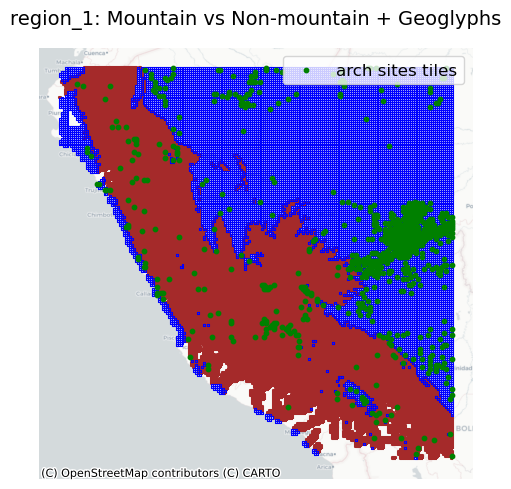

/tmp/ipykernel_181/1614218849.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(fontsize=12, loc='upper right')


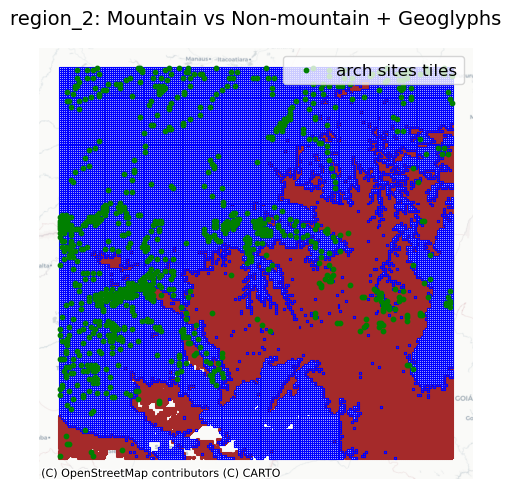

/tmp/ipykernel_181/1614218849.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(fontsize=12, loc='upper right')


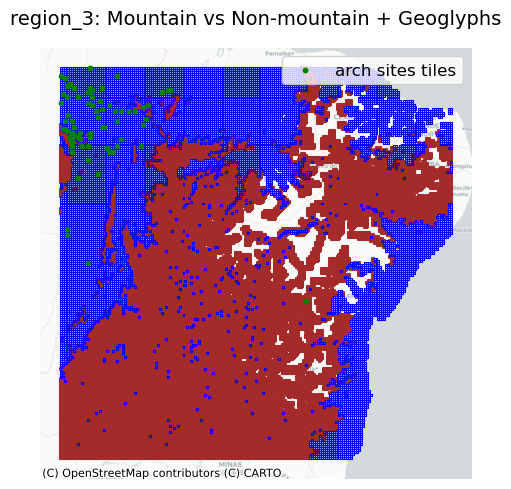

/tmp/ipykernel_181/1614218849.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(fontsize=12, loc='upper right')


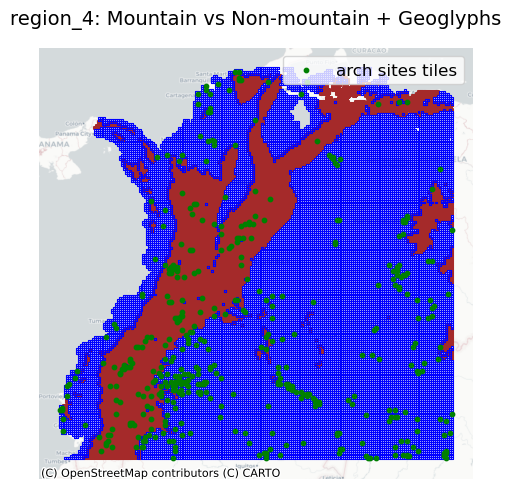

/tmp/ipykernel_181/1614218849.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(fontsize=12, loc='upper right')


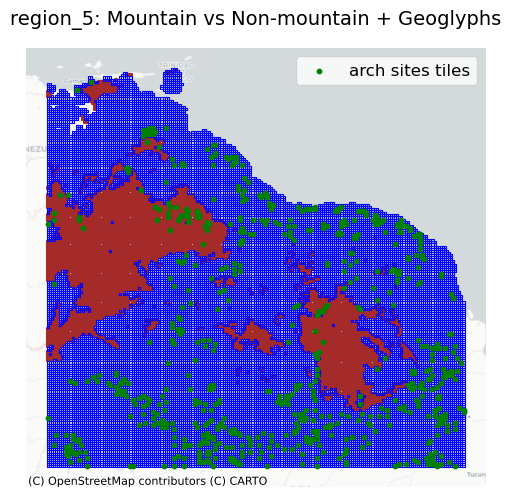

/tmp/ipykernel_181/1614218849.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(fontsize=12, loc='upper right')


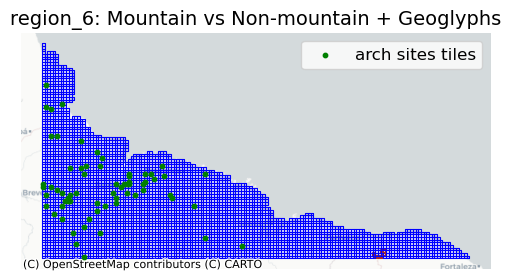

In [12]:
for name, gdf in regions_final.items():
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # 1) Mountain tiles
    gdf[gdf["is_mountain"]].to_crs("EPSG:3857") \
        .plot(ax=ax, edgecolor="brown", facecolor="none", linewidth=1.5, label="Mountain tiles")
    
    # 2) Non-mountain tiles
    gdf[~gdf["is_mountain"]].to_crs("EPSG:3857") \
        .plot(ax=ax, edgecolor="blue", facecolor="none", linewidth=0.8, label="Non-mountain tiles")
    
    # 3) Geoglyph‐containing tile centroids
    if "has_geoglyph" in gdf.columns:
        geoglyph_gdf = gdf[gdf["has_geoglyph"]].to_crs("EPSG:3857")
        gpd.GeoSeries(geoglyph_gdf.geometry.centroid, crs="EPSG:3857") \
            .plot(ax=ax, marker='o', color='green', markersize=10, label="arch sites tiles", zorder=5)
    
    # 4) Basemap
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    
    # 5) Final touches
    ax.set_title(f"{name}: Mountain vs Non-mountain + Geoglyphs", fontsize=14)
    ax.legend(fontsize=12, loc='upper right')
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

In [14]:
regions_with_dist = {}

for name, gdf in regions_final.items():
    print(f"📍 Processing {name} ({len(gdf)} features)…")
    gdf_dist = get_distance_to_rivers_parallel(
        geo_gdf= gdf,
        riv_gdf= main_rivers_web,
        geometry_col= "geometry",
        n_jobs= -1
    )
    regions_with_dist[name] = gdf_dist

📍 Processing region_1 (29701 features)…


/tmp/ipykernel_181/178796381.py:177: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  river_union = riv_gdf.geometry.unary_union
dist-to-river (geometry): 100%|██████████| 29701/29701 [04:48<00:00, 102.87it/s]


📍 Processing region_2 (39343 features)…


/tmp/ipykernel_181/178796381.py:177: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  river_union = riv_gdf.geometry.unary_union
dist-to-river (geometry): 100%|██████████| 39343/39343 [10:01<00:00, 65.40it/s]


📍 Processing region_3 (31564 features)…


/tmp/ipykernel_181/178796381.py:177: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  river_union = riv_gdf.geometry.unary_union
dist-to-river (geometry): 100%|██████████| 31564/31564 [08:08<00:00, 64.56it/s]


📍 Processing region_4 (32909 features)…


/tmp/ipykernel_181/178796381.py:177: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  river_union = riv_gdf.geometry.unary_union
dist-to-river (geometry): 100%|██████████| 32909/32909 [08:21<00:00, 65.63it/s]


📍 Processing region_5 (29853 features)…


/tmp/ipykernel_181/178796381.py:177: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  river_union = riv_gdf.geometry.unary_union
dist-to-river (geometry): 100%|██████████| 29853/29853 [07:40<00:00, 64.84it/s]


📍 Processing region_6 (4381 features)…


/tmp/ipykernel_181/178796381.py:177: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  river_union = riv_gdf.geometry.unary_union
dist-to-river (geometry): 100%|██████████| 4381/4381 [01:07<00:00, 65.21it/s]


In [22]:
regions_with_dist['region_1'].head(2).round(2)

,tile_id,n_geoglyphs,has_geoglyph,name_list,coordinates_list,source_list,bbox_list,longitude_list,latitude_list,geometry,mean_elev_m,mean_slope_deg,geometry_point,is_mountain,dist_to_mountain_m,dist_to_river_m
0,122412,0,False,[],[],[],[],[],[],"POLYGON ((-80.55834 -3.49939, -80.55834 -3.424...",NaN,0.0,POINT (-80.59584 -3.46189),False,0.44,4001122.46
1,122413,0,False,[],[],[],[],[],[],"POLYGON ((-80.48334 -3.49939, -80.48334 -3.424...",3.1,0.0,POINT (-80.52084 -3.46189),False,0.40,4001122.53


In [25]:
# 🌊 Add river-related features to each region
regions_with_river_features = {}

for name, gdf in regions_with_dist.items():
    print(f"🌊 Enriching {name} with river features")

    # 1. Ensure 'geometry_point' exists for spatial joins
    if "geometry_point" not in gdf.columns:
        gdf = add_geometry_point(gdf, method="centroid")

    # 2. Add distance to nearest river and its attributes (ORD_FLOW, UPLAND_SKM)
    gdf_riv = add_river_attrs_sjoin(
        tiles=gdf,
        rivers=main_rivers_web,
        tile_pt_col="geometry_point",
        river_geom_col="geometry",
        river_rank_col="ORD_FLOW",
        river_area_col="UPLAND_SKM",
        metric_crs=METRIC_CRS
    )

    # 3. Compute drainage density and tile area
    gdf_riv = compute_drainage_density(
        tiles_gdf=gdf_riv,
        rivers_gdf=main_rivers_web,
        tile_geom_col="geometry",
        river_geom_col="geometry",
        metric_crs=METRIC_CRS,
        source_crs=AOI_CRS
    )

    # 4. Save updated region
    regions_with_river_features[name] = gdf_riv


🌊 Enriching region_1 with river features


drainage_density: 100%|██████████| 32054/32054 [00:42<00:00, 758.80tile/s] 


🌊 Enriching region_2 with river features


drainage_density: 100%|██████████| 42557/42557 [00:54<00:00, 774.28tile/s] 


🌊 Enriching region_3 with river features


drainage_density: 100%|██████████| 34578/34578 [00:34<00:00, 993.90tile/s] 


🌊 Enriching region_4 with river features


drainage_density: 100%|██████████| 35295/35295 [00:50<00:00, 695.11tile/s]


🌊 Enriching region_5 with river features


drainage_density: 100%|██████████| 32145/32145 [00:43<00:00, 736.41tile/s]


🌊 Enriching region_6 with river features


drainage_density: 100%|██████████| 4652/4652 [00:06<00:00, 768.83tile/s]


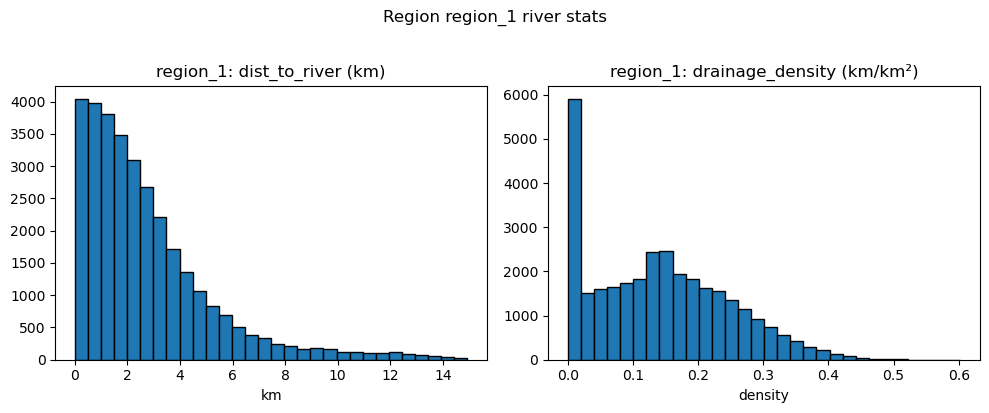

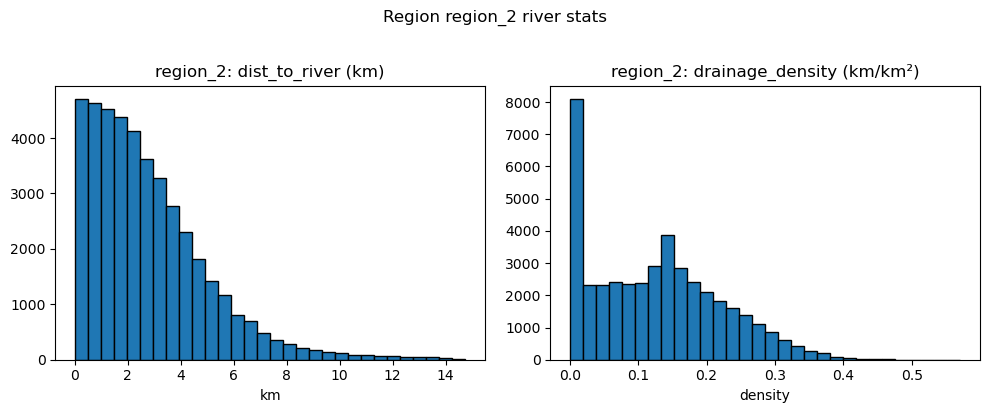

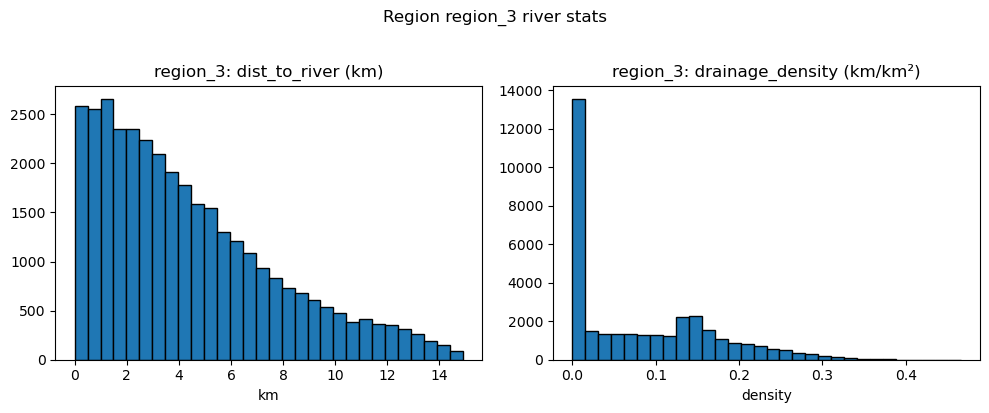

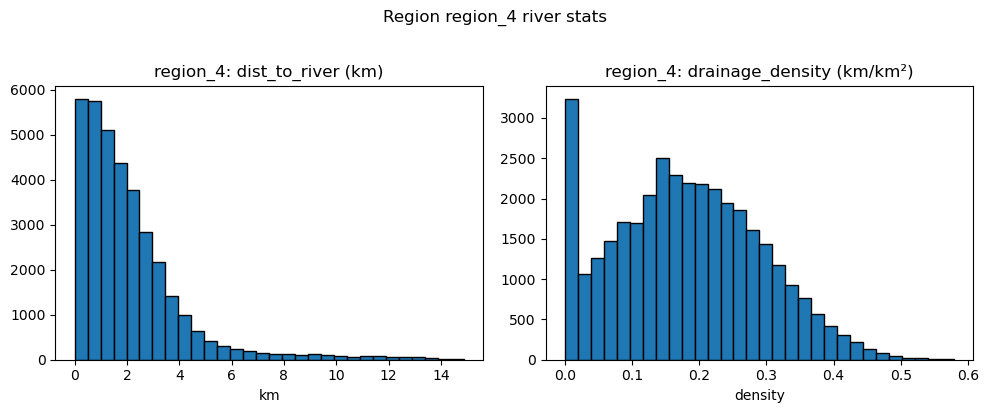

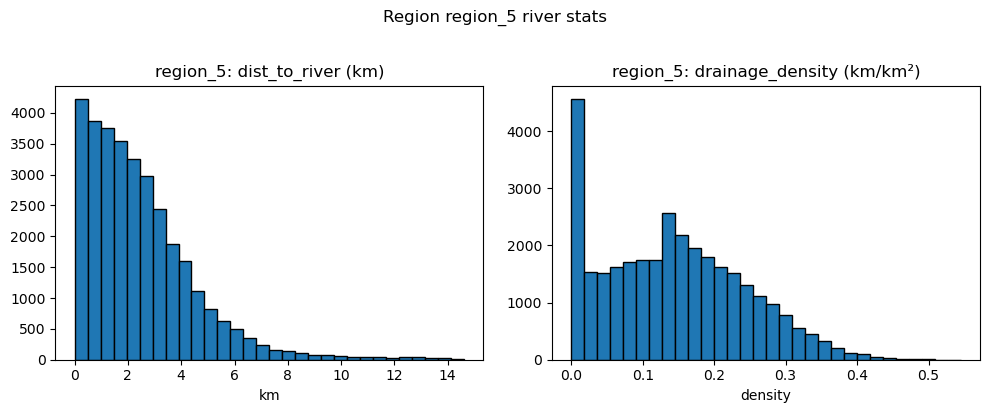

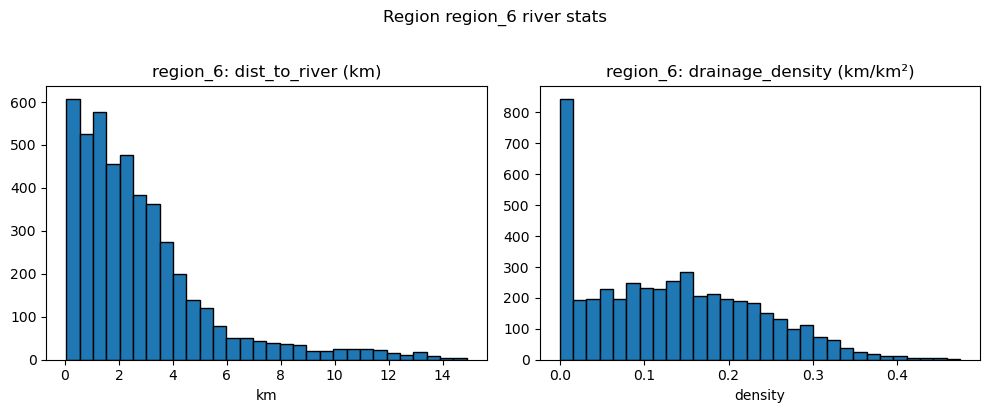

In [26]:
for name, gdf in regions_with_river_features.items():
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    
    ax[0].hist(gdf["dist_to_river_m"]/1000, bins=30, edgecolor="black")
    ax[0].set_title(f"{name}: dist_to_river (km)")
    ax[0].set_xlabel("km")
    
    ax[1].hist(gdf["drainage_density"], bins=30, edgecolor="black")
    ax[1].set_title(f"{name}: drainage_density (km/km²)")
    ax[1].set_xlabel("density")
    
    plt.suptitle(f"Region {name} river stats", y=1.02)
    plt.tight_layout()
    plt.show()

In [65]:
# 1. Update geometry_point with correct CRS
regions_updated = {}
for name, gdf in regions_with_river_features.items():
    print(f"📍 Updating geometry_point and projecting to {METRIC_CRS}: {name}")
    gdf = gdf.to_crs(METRIC_CRS)  # must come before geometry_point
    gdf = add_geometry_point(gdf, method="centroid")
    regions_updated[name] = gdf

# 2. Flatten tiles (one row per geoglyph or empty row if none)
flattened = {}
for region, tiles in regions_updated.items():
    flat = flatten_tile_hits_with_negatives(tiles)
    flat = flat.drop(columns=["index_right", "name"], errors="ignore")
    flat["region"] = region
    flattened[region] = flat
    print(f"{region}: {len(flat)} rows")

# 3. Load and normalize country polygons
countries_gdf = load_country_shapes(crs=METRIC_CRS, use_bbox=False)
if "ADMIN" in countries_gdf.columns:
    countries_gdf = countries_gdf.rename(columns={"ADMIN": "name"})
elif "NAME_EN" in countries_gdf.columns:
    countries_gdf = countries_gdf.rename(columns={"NAME_EN": "name"})
countries_gdf = countries_gdf[["name", "geometry"]]

# 4. Assign country by spatial join on geometry_point
regions_flat_with_country = {}
for region, flat in flattened.items():
    flat = flat.set_geometry("geometry_point")

    # Ensure correct CRS before spatial join
    if flat.crs is None:
        flat = flat.set_crs(METRIC_CRS, allow_override=True)
    else:
        flat = flat.to_crs(METRIC_CRS)

    joined = gpd.sjoin(flat, countries_gdf, how="left", predicate="within")
    out = flat.copy()
    out["country"] = joined["name"]
    regions_flat_with_country[region] = out
    print(f"{region} → unique countries:", out["country"].dropna().unique())

# 5. Combine all regions into final GeoDataFrame
all_tiles_flat = pd.concat(
    regions_flat_with_country.values(), ignore_index=True
)
all_tiles_flat = gpd.GeoDataFrame(
    all_tiles_flat,
    geometry="geometry",
    crs=METRIC_CRS
)

print("\n✅ Total rows after combining all regions:", len(all_tiles_flat))
display(all_tiles_flat[["region", "tile_id", "has_geoglyph", "country"]].head(10))
print("🌍 Countries present:", all_tiles_flat["country"].dropna().unique())


📍 Updating geometry_point and projecting to EPSG:3857: region_1
📍 Updating geometry_point and projecting to EPSG:3857: region_2
📍 Updating geometry_point and projecting to EPSG:3857: region_3
📍 Updating geometry_point and projecting to EPSG:3857: region_4
📍 Updating geometry_point and projecting to EPSG:3857: region_5
📍 Updating geometry_point and projecting to EPSG:3857: region_6
region_1: 37651 rows
region_2: 43846 rows
region_3: 34589 rows
region_4: 35464 rows
region_5: 32870 rows
region_6: 4702 rows
region_1 → unique countries: ['Peru' 'Ecuador' 'Colombia' 'Brazil' 'Bolivia']
region_2 → unique countries: ['Brazil' 'Bolivia']
region_3 → unique countries: ['Brazil']
region_4 → unique countries: ['Colombia' 'Venezuela' 'Brazil' 'Ecuador' 'Peru']
region_5 → unique countries: ['Venezuela' 'Guyana' 'Suriname' 'Brazil']
region_6 → unique countries: ['Brazil']

✅ Total rows after combining all regions: 189122


,region,tile_id,has_geoglyph,country
0,region_1,122412,False,NaN
1,region_1,122413,False,NaN
2,region_1,122414,False,NaN
3,region_1,122415,False,Peru
4,region_1,122416,False,Peru
5,region_1,122417,False,Ecuador
6,region_1,122418,False,Ecuador
7,region_1,122419,False,Ecuador
8,region_1,122420,False,Ecuador
9,region_1,122421,False,Ecuador


🌍 Countries present: ['Peru' 'Ecuador' 'Colombia' 'Brazil' 'Bolivia' 'Venezuela' 'Guyana'
 'Suriname']


In [64]:
with open(os.path.join(PROCESSED_DIR, "all_tiles_flat.pkl"), "wb") as f:
    pickle.dump(all_tiles_flat, f)